In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft
import swyft.lightning as sl
import lensing_model
from pytorch_lightning import loggers as pl_loggers
from pyrofit.lensing.sources import SersicSource

import sys
sys.path.append('../16-swyft_unet/scripts/')
from plot import *
from unet import UNET
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top
from pyrofit.lensing.distributions import get_default_shmf

from tqdm import tqdm
DEVICE = 'cuda'

from predict import Prior, Predict

from icecream import install
install()

## Problem-specific analysis components

In [3]:
KNN = 3
SIGMA = 0.00

nsub = NSUB = 1
nmc = NMC = 1
L = 40
low  = LOW = torch.tensor([-2.5, -2.5, 10.], device = DEVICE)
high = HIGH = torch.tensor([ 2.5,  2.5, 11.0], device = DEVICE)

class Model(sl.SwyftModel):
    def __init__(self):
        self.paramtrans = sl.CustomParameterTransform(nsub=NSUB, nmc=NMC, L=L, low=LOW, high=HIGH)
    
    
    def slow(self, pars):
        torch.cuda.set_device(0)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)    
        
#         x, y, phi, q, r_ein, slope = pars['z_lens'] 
        x, y, phi, q, r_ein, slope = -0.05, 0.1, 1., 0.75, 1.5, 2.1 # fix lens parameters for now
    
#         x_src, y_src, phi_src, q_src, index, r_e, I_e = pars['z_src']
        x_src, y_src, phi_src, q_src, index, r_e, I_e = 0., 0., 1., 0.5, 1., 1., 1. # fix source parameters for now
        
#         xy_sub, M_sub, nsub = pars['xy_sub'], pars['M_sub'], pars['nsub']
        z_sub = pars['z_sub']
#         z_sub[:,2] = z_sub[:,2]/1e11

        img, coords = lensing_model.image_generator_toy(x, y, phi, q, r_ein, slope, x_src, y_src, phi_src, q_src, index, r_e, I_e, z_sub)
        X, Y, Xsrc, Ysrc = coords
        kNN_idx = lensing_model.get_kNN_idx(X/5, -Y/5, Xsrc, Ysrc, k = KNN)  # TODO: Need to sort out strange 1/5 and -1/5 factors
        torch.set_default_tensor_type(torch.FloatTensor)
        return sl.SampleStore(mu = img.cpu())
    
    def fast(self, d):
        img = d['mu'] + torch.randn_like(d['mu'])*SIGMA
        return sl.SampleStore(img=img)
    
    def prior(self, N, bounds = None):
#         src_samples  = self.prior_sersic(N, bounds = bounds)
#         lens_samples = self.prior_lens(N, bounds = bounds)
        sub_samples  = self.prior_sub(N, bounds = bounds)
        return sl.SampleStore(**sub_samples)
    
    def prior_sersic(self, N, bounds = None):
        if bounds is not None:
            low = bounds['z_src'].low
            high = bounds['z_src'].high
        else:
            low =  np.array([-0.1, -0.1, 0, 0., 0.5, 0.1, 0.])
            high = np.array([0.1, 0.1, 1.5, 1., 4.0, 2.5, 4.])
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return sl.SampleStore(z_src = torch.tensor(draw).float())

    def prior_lens(self, N, bounds = None):
        if bounds is not None:
            low = bounds['z_lens'].low
            high = bounds['z_lens'].high
        else:
            low =  np.array([-0.2, -0.2, 0, 0.2, 1.0, 1.5])
            high = np.array([0.2, 0.2, 1.5, 0.9, 2.0, 2.5])
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return sl.SampleStore(z_lens = torch.tensor(draw).float())
    
    def prior_sub(self, N, bounds = None):
        nsub  = NSUB
        z_lens = 0.5
        
        if bounds is not None:
            low = bounds['z_lens'].low
            high = bounds['z_lens'].high
        else:
            low  = torch.tensor([-2.5, -2.5, 10.])
            high = torch.tensor([ 2.5,  2.5, 11.])
        
        xy_dist = torch.distributions.Uniform(low[[0, 1]], high[[0, 1]])
        M_dist  = get_default_shmf(z_lens = z_lens, log_range = (low[2], high[2]))
        
        xy_sub = xy_dist.sample((N, nsub))
        M_sub = M_dist.sample((N, nsub, 1))
        
        
        z_sub = torch.cat((xy_sub, M_sub), dim = 2)
        
        z_pix = self.paramtrans(z_sub.to(DEVICE)).cpu()
        
#         return sl.SampleStore(z_sub=z_sub, z_pix = z_pix)
        return sl.SampleStore(z_sub=z_sub)

    
m = Model();

  0%|          | 0/4 [00:00<?, ?it/s]/home/eliasd/lensing/pyrofit-utils/pyrofit/utils/torchutils.py:126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (indices.unsqueeze(-1) // strides) % shape
100%|██████████| 4/4 [00:00<00:00, 4129.27it/s]


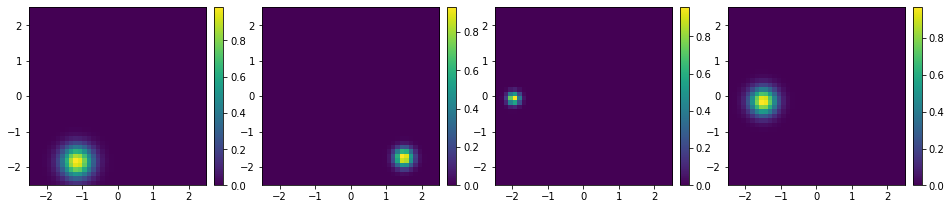

In [4]:
s_examples = m.sample(4)
plt_imshow( s_examples['img'],
           scatter = s_examples['z_sub'],
           cbar = True, **imkwargs )

In [5]:
paramtrans = sl.CustomParameterTransform(nsub, nmc, L, low, high)

In [9]:
s0['img'].shape

torch.Size([1, 40, 40])

In [16]:
paramtrans(s0['z_sub'].to(DEVICE)).squeeze(0).shape

torch.Size([1, 40, 40])

100%|██████████| 1/1 [00:00<00:00, 3758.34it/s]


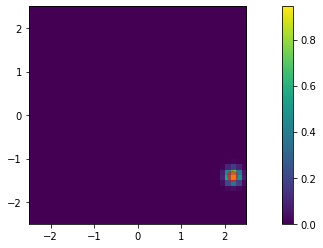

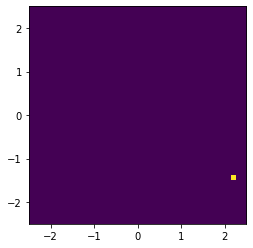

In [17]:
s0 = m.sample(1)
plt_imshow( s0['img'], circles = s0['z_sub'], cbar = True, **imkwargs , y = 4)
plt_imshow( paramtrans(s0['z_sub'].to(DEVICE)).squeeze(0).cpu(), **imkwargs, y = 4)

In [19]:
class SubNetwork(sl.SwyftModule):
    def __init__(self):
        super().__init__()
        
        nmc = NMC
        
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (L, L)))
        self.c = sl.RatioEstimatorImageSegmentation(nsub=nsub, nmc=nmc, L=L, low=low, high=high)
        
    def forward(self, x, z):
        x = dict(img = x['img'])
        x = self.online_z_score(x)['img']
        
        # x = x * z #?
        # x = torch.sum(x, axis = 2) #?
        
       
        
        out = self.c(x, z['z_sub'])
        return dict(z_pix = out)
    
Ntrain1, R1, ME = 5000, 1, 5 # Number of training simulations, number of training rounds (?), max epochs 
# Ntrain1, R1, ME = 500, 1, 2 # Number of training simulations, number of training rounds (?), max epochs 
TARGET = 1
tag = 'sub_v2'

bounds = None
s00 = s0[0]
results = []
for i in range(R1):
    tbl = pl_loggers.TensorBoardLogger("lightning_logs", name = 'lensing_%s'%tag)#, default_hp_metric=True)
    # s1: img, lens, src ~ p(img|lens, src)p(lens)p(src)
    s1 = sl.file_cache(lambda: m.sample(Ntrain1, bounds = bounds), './train_data_%s_%i_%i_%i.pt'%(tag, TARGET, Ntrain1, i))
    
    # r1: p(z_lens|img)/p(z_lens)
    r1 = SubNetwork()
    
    # d1: split img vs z_lens
    # TODO: Specify x_keys = ['img'], z_keys=['z_lens']
    d1 = sl.SwyftDataModule(store = s1, model = m, batch_size = 128)
    
    # Train r1 with d1
    t1 = sl.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = ME, logger = tbl)
    t1.fit(r1, d1)
    t1.test(r1, d1)
    
    # p1: z_lens ~ p(z_lens|img_obs)  --  these are weighted samples
#     p1 = t1.infer(r1, d1)
    
    

        
#     bounds = None #sl.get_1d_rect_bounds(all_inference, th = 1e-6)  # for p(z_lens)
#     results.append(dict(p1=p1, bounds = bounds))
    


100%|██████████| 5000/5000 [00:05<00:00, 918.23it/s]

100%|██████████| 5000/5000 [00:00<00:00, 31731.76it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: lightning_logs/lensing_sub_v2
Set SLURM handle signals.

  | Name           | Type                            | Params
-------------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer    | 0     
1 | c              | RatioEstimatorImageSegmentation | 31.0 M
-------------------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': 2216.96630859375, 'hp/KL-div': -11.207215309143066}
--------------------------------------------------------------------------------


In [20]:
predict = Predict(nsub, nmc, L, low, high)
prior = predict.prior.cpu().detach().numpy()

ic| self.low[-1]: tensor(10., device='cuda:0')
    self.high[-1]: tensor(11., device='cuda:0')
ic| m: tensor([1.0000e+10, 3.1623e+10, 1.0000e+11])
ic| m_centers: tensor([3.1623e+10])
    m_edges: tensor([1.0000e+10, 1.0000e+11])
ic| self.low[-1]: tensor(10., device='cuda:0')
    self.high[-1]: tensor(11., device='cuda:0')
ic| m: tensor([1.0000e+10, 3.1623e+10, 1.0000e+11])
ic| m_centers: tensor([3.1623e+10])
    m_edges: tensor([1.0000e+10, 1.0000e+11])
ic| a: tensor(10., device='cuda:0'), b: tensor(11., device='cuda:0')
ic| shmf_frac: tensor([1.0000], device='cuda:0', dtype=torch.float64)
    torch.sum(shmf_frac): tensor(1.0000, device='cuda:0', dtype=torch.float64)
ic| self.nsub: 1, self.L: 40
ic| self.m_edges: tensor([1.0000e+10, 1.0000e+11])


Prior subhalo in Mass range
6.25e-04 	 [1.00e+10 - 9.99999980e+10]


In [ ]:
zsub = predict.get_1_z_sub(low, high, predict.m_edges, L)[1]['z_sub']

In [21]:
def get_target_coords(r1, s1):
    x, y = s1['z_sub'][:,:,[0,1]].squeeze().T
    target = r1.c.paramtrans(s1['z_sub'].to(DEVICE)).cpu().squeeze()
    m_i = torch.stack(torch.where(target == 1))[0]
    target_coords = torch.stack((m_i, x, y)).T
    return target_coords

In [22]:
l = 20
posts, targets = [], []
for _, s_batch in tqdm(zip(range(l), d1.test_dataloader()), total = l):
    posts.append(  predict(r1, s_batch[0]) )
    targets.append( r1.c.paramtrans(s_batch[0]['z_sub'].to(DEVICE)) )
posts = torch.cat(posts)
targets = torch.cat(targets)


100%|██████████| 20/20 [01:04<00:00,  3.23s/it]


In [23]:
n_alpha = 50
alpha_edges = torch.linspace(0, 1, n_alpha, device = DEVICE, dtype=torch.float64)
alpha_centers = (alpha_edges[:-1] + alpha_edges[1:])/2

In [24]:
posts_alpha = torch.repeat_interleave(posts.unsqueeze(-1), n_alpha-1, dim = -1)
targets_alpha = torch.repeat_interleave(targets.unsqueeze(-1), n_alpha-1, dim = -1)

In [25]:
is_between = (posts_alpha > alpha_edges[:-1]) & (posts_alpha < alpha_edges[1:])

In [26]:
is_between_sum = torch.sum(targets_alpha * is_between, dim = (0, 1, 2, 3))

In [27]:
hist, _ = torch.histogram(posts.flatten().cpu(), bins = alpha_edges.cpu())

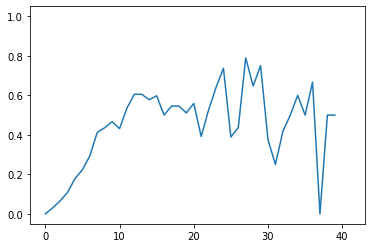

In [28]:
plt.plot( (is_between_sum/hist.to(DEVICE)).cpu().detach().numpy())

In [29]:
s1 = m.sample(1)


  0%|          | 0/1 [00:00<?, ?it/s]/home/eliasd/lensing/pyrofit-utils/pyrofit/utils/torchutils.py:126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (indices.unsqueeze(-1) // strides) % shape
100%|██████████| 1/1 [00:00<00:00, 150.04it/s]

100%|██████████| 1/1 [00:00<00:00, 902.58it/s]


RuntimeError: stack expects each tensor to be equal size, but got [1] at entry 0 and [] at entry 1

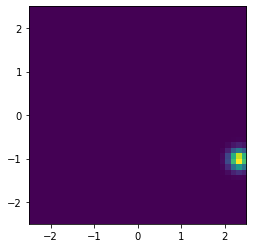

In [30]:
pred = predict(r1, s1).cpu().detach().numpy()

plt.imshow(s1['img'].squeeze(), **imkwargs)

plt_imshow(pred.squeeze(), cbar = True,
           zlog = True,
           target_coords=get_target_coords(r1, s1),
           title = fr"$\sum_{{ijk}} \, p(\theta|x_{{ijk}})= {np.sum(pred):.2f}$",
           supx = 0.25, supy = 1.0, supsize = 20,
           **imkwargs, y = 4, 
           priors = prior
          ) 

In [ ]:
# grid = torch.linspace(low[0], high[0], L+1)[:-1]
# x, y = torch.meshgrid(grid, grid, indexing = 'xy')
# ms = [torch.full((x.shape), m_i) for m_i in m_edges[:-1]]

# z_sub_all   = torch.cat([ torch.stack((x, y, m), dim = 2).flatten(end_dim = 1) for m in ms]).unsqueeze(0).to(DEVICE)
# z_sub_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, 0, 3).to(DEVICE)

# z_sub_all = dict(z_sub = z_sub_all)
# z_sub_empty = dict(z_sub = z_sub_empty)

In [ ]:
# s1 = m.sample(1)

# logratios_all = []
# for _ in range(100):
#     logratios = torch.zeros((nmc*2, L, L), device = DEVICE)
#     logratios[:nmc] = r1(s1, z_sub_empty)['z_pix'].ratios.squeeze()
#     logratios[nmc:] = r1(s1, z_sub_all)['z_pix'].ratios.squeeze()
#     logratios_all.append(logratios)
# logratios_all = torch.stack(logratios_all)

# plt.plot( torch.mean(logratios_all[:-1] - logratios_all[1:], dim = (1, 2, 3)).cpu().detach() )

In [ ]:
# s00 = s0.copy()
# for k, v in s00.items():
#     s00[k] = v.unsqueeze(0)

In [ ]:
assert 1 == 2

In [ ]:
# logratios = torch.zeros((nmc*2, L, L), device = DEVICE)
# logratios[:nmc] = r1(s1, z_sub_empty)['z_pix'].ratios.squeeze()
# logratios[nmc:] = r1(s1, z_sub_all)['z_pix'].ratios.squeeze()

# logratios2 = torch.zeros((nmc*2, L, L), device = DEVICE)
# logratios2[:nmc] = r1(s1, z_sub_empty)['z_pix'].ratios.squeeze()
# logratios2[nmc:] = r1(s1, z_sub_all)['z_pix'].ratios.squeeze()




In [ ]:
post_sum = torch.sum(torch.transpose( posts.reshape(2, nmc, L, L), 0, 1), dim = 1)
post_norm = posts[nmc:] / post_sum
plt_imshow( post_norm.cpu().detach().numpy() , cbar = True, **imkwargs)

In [ ]:
plt_imshow( priors[nmc:].cpu().detach().numpy(), cbar = True, **imkwargs)

In [ ]:
plt_imshow(paramtrans(predict.z_sub_all['z_sub']).squeeze().cpu(), cbar = True, y = 4)

In [ ]:
plt_imshow(paramtrans(predict.z_sub_empty['z_sub']).squeeze().cpu(), cbar = True, y = 4)

In [ ]:
prior = Prior(nsub, nmc, L, low, high)

In [ ]:
prior.calc_prior()

In [ ]:
assert 1==2

In [ ]:
priors.shape

In [ ]:
plt_imshow(priors , cbar = True, tl = True)

In [ ]:
logratios = p1['z_pix'].ratios

In [ ]:
logratios.shape

In [ ]:
plt_imshow( s0['img'].unsqueeze(0),
           scatter = s0['z_sub'].unsqueeze(0),
           cbar = True,
           **imkwargs )

In [ ]:
plt_imshow( (torch.mean(logratios, dim = 0) ), cbar = True, **imkwargs)

In [ ]:
plt_imshow( torch.exp(torch.mean(logratios, dim = 0)), cbar = True)

In [ ]:
rand_int = torch.randint(high = Ntrain1, size = (5,))
for ratios, values in zip(p1['z_pix'].ratios[[rand_int]], p1['z_pix'].values[[rand_int]]):
    plt_imshow(ratios, 
               scatter = torch.stack((values, values, values)),
               **imkwargs, cbar = True)
    plt_imshow(ratios, 
#                scatter = torch.stack((values, values, values)),
               **imkwargs, cbar = True)
    plt_imshow( paramtrans(values.unsqueeze(0).to(DEVICE)).squeeze()[:nmc].cpu(), **imkwargs )